In [ ]:
#importing all the libraries

import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import cv2
import os
import math
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [ ]:
from torchvision import models
from torchvision import transforms
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir =  "/content/drive/MyDrive/NFT DATASET(Only Train)/Train"
dataset = ImageFolder(data_dir,transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224)),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]))
print(len(dataset))

611


In [ ]:
# Sizes of all the sets
train_size = 487
val_size = 62
test_size= 62
batch_size = 85

In [ ]:
#Splitting and Loading the sets
train_data,val_data,test_data = random_split(dataset,[train_size,val_size,test_size])
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size=62, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_data, batch_size=62, num_workers = 2, pin_memory = True)

In [ ]:
classes = [0,1]  # Flooded - 0 Non-Flooded-1

In [ ]:
#This architecture is similar to what PyTorch uses as it's pretrained model.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()                                             # N = ((n+2p-f)/s)+1

        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 11,stride=4,padding=2),              # output 56*56*64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),                              # Max Pool 27*27*64
            nn.Conv2d(64,192, kernel_size = 5, stride = 1, padding = 2),        # Same padding output 27*27*192
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),                              # output 13*13*192
        
            nn.Conv2d(192, 384, kernel_size = 3, stride = 1, padding = 1),      # Same padding output 13*13*384
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1),      # same padding output 13*13*256
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),      # Same padding output 13*13*256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),                              # output 6*6*256        
                                                                                # output 6*6*256
            nn.AdaptiveAvgPool2d(output_size=(6,6)),
            nn.Dropout(p=0.5,inplace=False),

            #Linear Layers
            nn.Flatten(),   
            nn.Linear(9216,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096,1000),
            nn.ReLU(),
            nn.Linear(1000,2),
        )
    
    def forward(self, xb):
        return self.network(xb)

# create a complete CNN
model = Net()
print(model)

Net(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): AdaptiveAvgPool2d(output_size=(6, 6))
    (14): Dropout(p=0.5, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=9216, out_features=4096, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.5, inplace=False)

In [ ]:
def train(model, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reset the optimizer
        optimizer.zero_grad()
        output = model(data)
        # Get the loss
        loss = loss_criteria(output, target)
        # Keep a running total
        train_loss += loss.item()
        # Backpropagate
        loss.backward()
        optimizer.step()
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))     
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [ ]:
def test(model, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 15 epochs
epochs = 15
for epoch in range(1, epochs + 1):
        train_loss = train(model, train_dl, optimizer, epoch)
        test_loss = test(model, val_dl)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


	Training batch 1 Loss: 0.693487
	Training batch 2 Loss: 2.803308
	Training batch 3 Loss: 0.691742
	Training batch 4 Loss: 0.750700
	Training batch 5 Loss: 0.696697
	Training batch 6 Loss: 0.691559
Training set: Average loss: 1.054582
Validation set: Average loss: 0.685502, Accuracy: 27/62 (44%)

Epoch: 2
	Training batch 1 Loss: 0.696914
	Training batch 2 Loss: 0.683713
	Training batch 3 Loss: 0.679182
	Training batch 4 Loss: 0.660222
	Training batch 5 Loss: 0.853369
	Training batch 6 Loss: 0.650884
Training set: Average loss: 0.704048
Validation set: Average loss: 0.698091, Accuracy: 35/62 (56%)

Epoch: 3
	Training batch 1 Loss: 0.668712
	Training batch 2 Loss: 0.678039
	Training batch 3 Loss: 0.697466
	Training batch 4 Loss: 0.728368
	Training batch 5 Loss: 0.642914
	Training batch 6 Loss: 0.708822
Training set: Average loss: 0.687387
Validation set: Average loss: 0.665001, Accuracy: 35/62 (56%)

Epoch: 4
	Training batch 1 Loss: 0.652270
	Training batch 2 Loss: 0.645863
	Training bat

In [ ]:
#Evaluating the model
test(model,test_dl)

Validation set: Average loss: 0.237148, Accuracy: 58/62 (94%)



0.23714777827262878

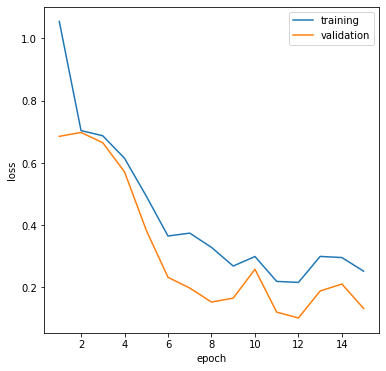

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
dataiter = iter(test_dl)
images, labels = dataiter.next()
classes = ('Flooded', 'Non-Flooded')
# print images
im_grid=torchvision.utils.make_grid(images[0:8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  Non-Flooded	 Flooded	 Non-Flooded	 Flooded	 Non-Flooded	 Non-Flooded	 Non-Flooded	 Non-Flooded	
Predicted:    Non-Flooded	 Flooded	 Non-Flooded	 Flooded	 Non-Flooded	 Non-Flooded	 Non-Flooded	 Flooded	


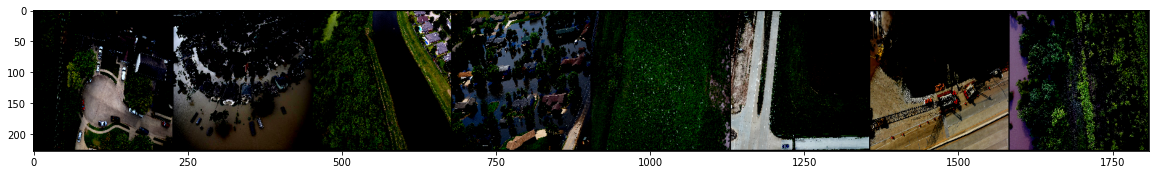

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(im_grid.permute(1,2, 0))
print('GroundTruth: ', ' '.join('%s\t' % classes[labels[j]] for j in range(8)))
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%s\t' % classes[predicted[j]] for j in range(8)))